# En este cuaderno crearemos un catálogo de las obras disponibles en la plataforma [Teatrix](https://www.teatrix.com/), analizaremos algunos de sus datos y finalmente extraeremos el listado en un archivo de Excel.

En primer lugar, importamos las librerías necesarias para obtener el código de la página y filtrarlo mediante expresiones regulares:

In [22]:
import requests
import re

Hacemos el pedido a la web. Si el valor de su estatus es igual a 200, quiere decir que hemos tenido éxito:

In [23]:
url = 'https://www.teatrix.com/'
request = requests.get(url)
request.status_code

200

A continuación obtenemos los nombres de las páginas que contienen cada una de las obras, ubicados en el texto luego de la expresión "video/".

In [24]:
pattern = 'video/(.+)">'
nombres = re.findall(pattern,request.text)
print(f'La página principal de Teatrix nos devuelve {len(nombres)} nombres de obras')

La página principal de Teatrix nos devuelve 446 nombres de obras


Cada obra puede aparecer más de una vez en la página principal de Teatrix, por lo cual necesitamos eliminar los nombres que sobran. Para esto, simplemente los convertimos en llaves de un diccionario. Esto descartará los repetidos y nos permitirá pisar la lista existente con la que realmente queremos:

In [25]:
nombres = list(dict.fromkeys(nombres))
print(f'Actualmente, Teatrix cuenta con {len(nombres)} obras en su catálogo.')

Actualmente, Teatrix cuenta con 178 obras en su catálogo.


A continuación creamos una lista que contenga nombre, teatro, año, duración y el link al trailer de cada una de las obras. Es probable que la siguiente celda tarde un par de minutos en ejecutarse, ya que debe recorrer página por página y filtrar los datos que queremos en cada una de ellas:

In [26]:
data = [] #Primero creamos la lista que iremos llenando con los datos de cada obra.
for i in nombres: #Creamos un bucle que itere el proceso en la página de cada obra.
  obra_data = [] #Creamos una lista vacía cada vez que se inicia un ciclo.
  while obra_data == []: #A veces al extraer los datos de la página nos puede pasar
  #que obtengamos un objeto vacío, dependiendo de cada carga. Por eso le pedimos
  #a Python que revise la lista que acabamos de crear y repita el ciclo mientras
  #el resultado esté vacío.
    obra = requests.get(f'https://www.teatrix.com/video/{i}') #Hacemos el request
    #correspondiente a esta obra.
    pattern_titulo = 'title">(.+)</h2' #Filtramos el título...
    obra_data += [i.title() for i in re.findall(pattern_titulo,obra.text)]
    pattern_teatro = 'origin">(.+)</span>' #...el teatro...
    obra_data += re.findall(pattern_teatro,obra.text)
    pattern_anio = 'date">(\d+)' #...el año...
    obra_data += re.findall(pattern_anio,obra.text)
    pattern_sinopsis = 'md">\s*(.+)' #...la sinopsis...
    obra_data += re.findall(pattern_sinopsis,obra.text)
    pattern_duracion = 'duration">(\d+)  min' #...y la duración.
    obra_data += re.findall(pattern_duracion,obra.text) 
  if len(obra_data) == 4: #Como hay obras cuya duración no figura en la página,
  #revisamos la cantidad de elementos que se extrajeron hasta el momento. Si hay
  #solo 4 quiere decir que no se halló el dato en cuestión. En ese caso agregamos
  #un valor nulo para que todas las listas tengan la misma longitud, condición
  #que será necesaria cuando queramos crear nuestra tabla.
    obra_data.append(None)
  obra_data += [f'https://www.teatrix.com/ver/{i}'] #Finalmente, sumamos el link
  #al trailer y...
  data.append(obra_data) #... finalizamos el ciclo sumando la lista de esta obra
  #a la general.

Vemos los primeros cinco elementos para comprobar que el proceso haya sido exitoso:

In [27]:
data[:5]

[['Mucho',
  'Paseo La Plaza',
  '2020',
  'MUCHO estuvo tres años en cartel en el Paseo La Plaza, es el show más reciente del grupo Más Canchero protagonizado y escrito por Diego Scott, Fernando Sanjiao, Malena Guinzburg y Pablo Fábregas, con la dirección de Diego Reinhold.\r',
  '1',
  'https://www.teatrix.com/ver/Mucho'],
 ['Homenaje A Hugo Arana: Todas Las Rayuelas',
  'Teatrix',
  '2017',
  'No podíamos cerrar este año sin realizar un merecido homenaje a Hugo Arana. Y se nos ocurrió que la mejor manera de homenajear a un tipazo como el queridísimo Huguito es disfrutando de su arte en un evento solidario.&nbsp;</p>',
  None,
  'https://www.teatrix.com/ver/homenaje-a-hugo-arana-todas-las-rayuelas'],
 ['La Hora De La Calabaza',
  'Teatro Payró',
  '2017',
  'La hora de la calabaza es el  instante exacto en el que se termina el hechizo de la pasión, y cada uno es lo que es frente al otro; el instante en el que la magia desaparece para convertirse en cruel realidad, en el que todas las

Ahora importamos la librería Pandas que nos ayudará a crear nuestro Dataset:

In [28]:
import pandas as pd

Hacemos una lista con los nombres que utilizará Pandas para crear las columnas:

In [29]:
columnas = ['Obra', 'Teatro', 'Año', 'Sinopsis', 'Duración_minutos', 'Trailer']

Ahora sí, creamos nuestro catálogo y lo revisamos tomando una muestra al azar:

In [30]:
catalogo = pd.DataFrame(data, columns = columnas)

In [31]:
catalogo.sample(5)

,Obra,Teatro,Año,Sinopsis,Duración_minutos,Trailer
128,El Botella,Centro Cultural 25 de mayo,2017,Que\r,95,https://www.teatrix.com/ver/el-botella
109,Los Amados,SALA SIRANUSH,2015,"La música de Agustín Lara enamora,\r divierte ...",70,https://www.teatrix.com/ver/los-amados
53,Jettatore!,Cultural San Martín,2018,"Esta comedia de puertas, contiene\r",81,https://www.teatrix.com/ver/jettatore
175,Los Dias De Julián Bisbal,Canal 9,1996,Un hombre de 40 años se enfrenta a una rutina ...,102,https://www.teatrix.com/ver/los-dias-de-julian...
16,Stéfano,Teatro Andamio,2019,Armando Discépolo es nuestro Shakespeare y Sté...,89,https://www.teatrix.com/ver/stefano


¿Coincide la cantidad de nombres que extrajimos al principio con la longitud del DataFrame?

In [32]:
len(nombres) == len(catalogo)

True

¿Cuáles son las obras más viejas del catálogo?

In [33]:
catalogo[catalogo['Año'] == catalogo['Año'].min()]

,Obra,Teatro,Año,Sinopsis,Duración_minutos,Trailer
5,Brujas,Teatro Ateneo,1992,"Moria Casán, Graciela Dufau, Nora Cárpena, The...",102,https://www.teatrix.com/ver/brujas
170,Alta Comedia: Hoy Digo Basta,Canal 9,1992,"Un episodio de Alta Comedia, el histórico cicl...",74,https://www.teatrix.com/ver/alta-comedia-hoy-d...
171,Alta Comedia: Persona No Grata,Canal 9,1992,"Un episodio de Alta comedia, el histórico cicl...",54,https://www.teatrix.com/ver/alta-comedia-perso...
172,Alta Comedia: Sin Salida,Canal 9,1992,"Un episodio de Alta comedia, el histórico cicl...",70,https://www.teatrix.com/ver/alta-comedia-sin-s...
173,Alta Comedia: La Sangre De Los Ortiz,Canal 9,1992,"Un episodio de Alta comedia, el histórico cicl...",61,https://www.teatrix.com/ver/alta-comedia-la-sa...
174,Alta Comedia: Seis Personajes En Busca De Un A...,Canal 9,1992,"Un episodio de Alta comedia, el histórico cicl...",64,https://www.teatrix.com/ver/alta-comedia-seis-...


¿De qué años son la mayoría de las obras?

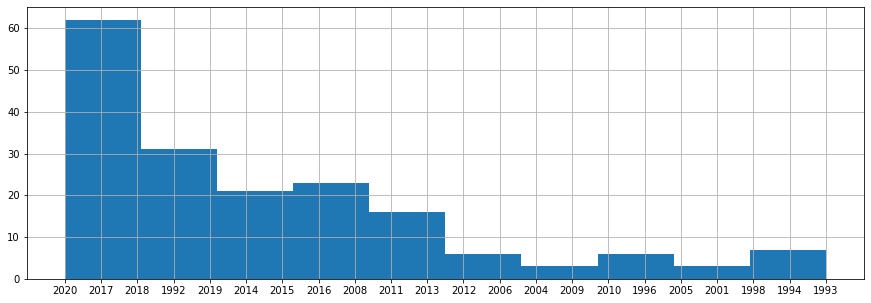

In [34]:
catalogo['Año'].hist(figsize=(15,5))

Ahora crearemos otro DataFrame para analizar la duración de las obras, eliminando los valores nulos, convirtiendo los minutos en datos operables y descartando aquellos que resulten anómalos:

In [35]:
duraciones = catalogo.dropna()

In [36]:
duraciones['Duración_minutos'] = duraciones['Duración_minutos'].astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [37]:
#Descartamos las obras que duren menos de 20 minutos, cifra arbitraria que tomamos
#como indicadora de datos anómalos:
duraciones = duraciones[duraciones['Duración_minutos'] > 20] 

¿Cuál es la obra más corta?

In [38]:
duraciones[duraciones['Duración_minutos'] == duraciones['Duración_minutos'].min()]

,Obra,Teatro,Año,Sinopsis,Duración_minutos,Trailer
140,Isabel De Guevara,Centro cultural 25 de mayo,2018,Una obra de la prestigiosa Alicia Muño...,41,https://www.teatrix.com/ver/isabel-de-guevara


¿Y la más larga?

In [39]:
duraciones[duraciones['Duración_minutos'] == duraciones['Duración_minutos'].max()]

,Obra,Teatro,Año,Sinopsis,Duración_minutos,Trailer
142,"Esquizopeña, Intimidad Rioplatense",Paseo La Plaza,2015,"El inolvidable Fernando Peña, trasgresor y cre...",172,https://www.teatrix.com/ver/esquizopena-intimi...


¿Cuál es el promedio de duración de las obras?

In [40]:
prom_dur = duraciones['Duración_minutos'].mean()
print(f'El promedio de duración de las obras es de {round(prom_dur)} minutos.')

El promedio de duración de las obras es de 88 minutos.


¿Cómo se distribuyen las obras según su duración?

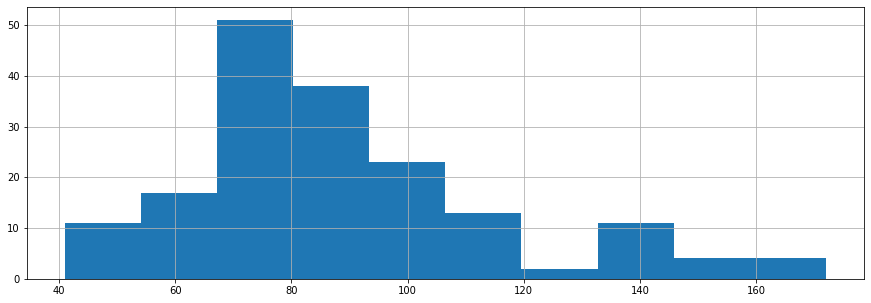

In [41]:
duraciones['Duración_minutos'].hist(figsize=(15,5))

Para finalizar, creamos un archivo de Excel con nuestro catálogo:

In [42]:
catalogo.to_excel('catalogo_teatrix.xlsx')